# Data EDA

Now, imagine that I am working for reddit and now reddit want to simplify the content posting process, so I employ an automated forum control tool, for users from r/nintendo and r/playstation.  
For example, I want to post some random thoughts, I really just want to make a quick post and I don't want to go to the individual forum.  
All I want to do is simply post, and as if by magic, this post will appear in the correct subreddit.  
This makes life so much simpler! 

Before I can enjoy this simple life, I need to first build a classifier to to the classification for me.  
Since I have the data now, I should analyse these data.  

---

This notebook is for EDA and preliminary model on `r/nintendo` and `r/playstation` data collected from reddit.  
There are about 1900 posts from each subreddit.  

Contents:
1. [EDA](#EDA)
2. [Prelim model](#Prelim-model)
3. [Further EDA](#Further-EDA)
4. [Conclusion](#Conclusion)

## EDA

In this section, data cleaning, EDA etc will be performed.

In [1]:
import joblib
import pickle
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

from scipy.stats import shapiro

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

from PIL import Image

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# Load data
ns_df = pd.read_csv('../data/nintendo_posts.csv')
display(ns_df.head())
display(ns_df.shape)

,id,title,post_content,user
0,119r7rg,THROWDOWN THURSDAY: LEAKS CONFIRM LINK IS IN T...,"WELCOME TO THROWDOWN THURSDAY, TURN YOUR CAPS ...",1338h4x
1,11c6ol7,"smile sunday - happy 30th anniversary, star fox!",turn your caps lock off and rave about whateve...,tale-wind
2,11cai3l,Never played a Pokémon game- where do I start?,I’ve been a gamer since early Gameboy days but...,Focusboy50
3,11bipdi,Universal Brazil posted a video of a Mario mov...,NaN,Nas160
4,11bkknf,MyNintendo offering eight exclusive reversible...,NaN,blubberpuppers


(1916, 4)

In [3]:
ps_df = pd.read_csv('../data/playstation_posts.csv')
display(ps_df.head())
display(ps_df.shape)

,id,title,post_content,user
0,11c5v5o,Recommendation Central,Looking for recommendations on what game to pl...,AutoModerator
1,11cgh82,My wife just got into a new crafting project a...,NaN,stanrandom
2,11bt09c,"When just saying ""I designs muscles and beards...",NaN,Mistah-S
3,11bl8dm,Just spotted a mouse cursor in one of forbidde...,NaN,Add1215
4,11bppbw,God of War Ragnarök PS5 Voucher/Code,NaN,eugenekk


(1988, 4)

There are 1916 posts from `r/nintendo` and 1988 posts from `r/playstation`.  
Let data from `r/nintendo` be labelled as 1, and `r/playstation` be labelled as 0.

In [4]:
# label the datas
ns_df['label'] = int(ns_df.shape[0])*[1]
ps_df['label'] = int(ps_df.shape[0])*[0]

# Concate the dataframes
df = pd.concat([ns_df, ps_df], axis=False, sort=False)
df.reset_index(drop=True, inplace=True)
df.head()

,id,title,post_content,user,label
0,119r7rg,THROWDOWN THURSDAY: LEAKS CONFIRM LINK IS IN T...,"WELCOME TO THROWDOWN THURSDAY, TURN YOUR CAPS ...",1338h4x,1
1,11c6ol7,"smile sunday - happy 30th anniversary, star fox!",turn your caps lock off and rave about whateve...,tale-wind,1
2,11cai3l,Never played a Pokémon game- where do I start?,I’ve been a gamer since early Gameboy days but...,Focusboy50,1
3,11bipdi,Universal Brazil posted a video of a Mario mov...,NaN,Nas160,1
4,11bkknf,MyNintendo offering eight exclusive reversible...,NaN,blubberpuppers,1


In [5]:
(df.isna().sum()/df.shape[0])*100

id               0.000000
title            0.000000
post_content    66.086066
user             4.585041
label            0.000000
dtype: float64

In [6]:
df.isna().sum()

id                 0
title              0
post_content    2580
user             179
label              0
dtype: int64

66.08% of the posts, or 2580, of the posts collected are not word posts.   
They are either video or picture posts.  
4.59% or 179 users doesn't have a user name.  
Maybe they are banned?  
It doesn't really matter now, as user name will not be used.

In [7]:
type(df['post_content'][8])

float

A key point that I should really remeber is that in pandas, `NaN` is represented using float...  
Also, `str(NaN)` will be `'nan'`...   

In [8]:
df['title_word_count'] = [len(title.split()) for title in df['title']]
df['title_len'] = [len(title) for title in df['title']]
df['post_word_count'] = [len(str(post).split()) if str(post) != 'nan' else 0 for post in df['post_content'] ]
df['post_len'] = [len(str(post)) if str(post) != 'nan' else 0 for post in df['post_content']]

In [9]:
df.head(10)

,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len
0,119r7rg,THROWDOWN THURSDAY: LEAKS CONFIRM LINK IS IN T...,"WELCOME TO THROWDOWN THURSDAY, TURN YOUR CAPS ...",1338h4x,1,11,65,114,674
1,11c6ol7,"smile sunday - happy 30th anniversary, star fox!",turn your caps lock off and rave about whateve...,tale-wind,1,8,48,231,1515
2,11cai3l,Never played a Pokémon game- where do I start?,I’ve been a gamer since early Gameboy days but...,Focusboy50,1,9,46,60,320
3,11bipdi,Universal Brazil posted a video of a Mario mov...,NaN,Nas160,1,21,114,0,0
4,11bkknf,MyNintendo offering eight exclusive reversible...,NaN,blubberpuppers,1,20,139,0,0
5,11bjztq,Nintendo Confirms It Won't Be at E3 2023,NaN,The_Norsican,1,8,40,0,0
6,11cfl9m,Darkside Detective Plushies!,I cant seem to find a dedicated Darkside Detec...,sweetypaw,1,3,28,72,997
7,11ckhq9,Live Factory - Launch Trailer - Nintendo Switch,NaN,Toxa17,1,8,47,0,0
8,11c4yp9,"[Video Tutorial] Joycon Grip Mod, with Magnets!",NaN,Onlyhereforthelaughs,1,7,47,0,0
9,11c8u5q,On This Day in Nintendo History: Dance Aerobic...,#On this day (February 21) in Nintendo history...,RoboticOperatingBudd,1,11,71,235,1386


In [10]:
# find the longest and shortest title len
display(df.sort_values(by='title_len', ascending=False).head(10))
display(df.sort_values(by='title_len', ascending=False).tail(10))

,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len
3106,pyfsvh,GOW voice actor Christopher Judge clarifies on...,NaN,CptnCASx,0,53,299,0,0
295,10s4cfj,"To celebrate Star Fox's 30th anniversary, I'm ...",NaN,AlphaSSB,1,54,298,0,0
1013,ai5d7n,"Sakurai: ""Smash Bros. is 20 years old today! O...",NaN,Lugia2453,1,52,287,0,0
1119,ni55it,"I am Giles Goddard, I made Star Fox with Shige...","I’m Giles Goddard, a game dev who programmed S...",CurrentCEOGiles,1,52,286,297,1740
1115,boebjd,"In Super Mario Odyssey, Mario is able to fall ...",NaN,NaN,1,48,280,0,0
1518,ic4nmi,"4 years, 2 months and 17 days ago I was in a d...",NaN,Biuzer,1,55,271,0,0
534,100f9a2,YSK - While Nintendo is well-known for sending...,While Nintendo has a reputation for taking dow...,razorbeamz,1,47,268,176,1001
1188,k58be5,"As of 2020, we are now in the longest drought ...",I honestly feel like this has been a much long...,TheJohnny346,1,52,266,45,236
3697,l6a3rb,This year marks 2 years since my really good f...,NaN,AlienJose,0,52,266,0,0
1650,8ytjyt,Confused by the difficulty of English in Octop...,NaN,NaN,1,40,265,0,0


,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len
3529,hqxhu2,Adios.,NaN,George05YT,0,1,6,0,0
3463,ecvaw4,Always,NaN,muffin-with-a-sword,0,1,6,0,0
2982,nrb7ro,welp..,NaN,hellserver02,0,1,6,0,0
3559,fwkmji,Me rn,NaN,REBELSHOCKER123,0,2,5,0,0
3621,kitbih,👏 👏 👏,NaN,NaN,0,3,5,0,0
3051,j9cjl7,Ooops,NaN,jas0ndrag0n,0,1,5,0,0
3053,dk8oc7,Facts,NaN,Robertcc99,0,1,5,0,0
3834,8tjwmc,Title,NaN,NaN,0,1,5,0,0
3101,hphb6m,Memes,NaN,emirology,0,1,5,0,0
3450,fdk9x6,💙💚,NaN,realdahdah,0,1,2,0,0


In [11]:
# Make a function to do the sorting as I have 4 colmuns to look at
def arrange_by(df, col_name, rows_shown = 5):
    '''Function that shows the sorted df
    Args:
        df: dataframe to sort
        col_name: colmun name to sort by
        rows_shown: number of rows to display for head and tail, default = 5
    '''
    if ((col_name == 'post_word_count') | (col_name == 'post_len')):
        df = df.dropna()
    display(df.sort_values(by=col_name, ascending=False).head(rows_shown))
    display(df.sort_values(by=col_name, ascending=False).tail(rows_shown))

In [12]:
arrange_by(df, 'title_word_count', 10)

,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len
1518,ic4nmi,"4 years, 2 months and 17 days ago I was in a d...",NaN,Biuzer,1,55,271,0,0
295,10s4cfj,"To celebrate Star Fox's 30th anniversary, I'm ...",NaN,AlphaSSB,1,54,298,0,0
3106,pyfsvh,GOW voice actor Christopher Judge clarifies on...,NaN,CptnCASx,0,53,299,0,0
3266,oc5fad,So I fked up my order (after trying since laun...,NaN,PanJan97,0,53,262,0,0
3801,pv9ary,Who else still likes to buy their games physic...,NaN,Ultimate_President,0,52,261,0,0
1119,ni55it,"I am Giles Goddard, I made Star Fox with Shige...","I’m Giles Goddard, a game dev who programmed S...",CurrentCEOGiles,1,52,286,297,1740
1188,k58be5,"As of 2020, we are now in the longest drought ...",I honestly feel like this has been a much long...,TheJohnny346,1,52,266,45,236
1013,ai5d7n,"Sakurai: ""Smash Bros. is 20 years old today! O...",NaN,Lugia2453,1,52,287,0,0
3697,l6a3rb,This year marks 2 years since my really good f...,NaN,AlienJose,0,52,266,0,0
1115,boebjd,"In Super Mario Odyssey, Mario is able to fall ...",NaN,NaN,1,48,280,0,0


,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len
3878,pjsuob,Evolution,NaN,NaN,0,1,9,0,0
3051,j9cjl7,Ooops,NaN,jas0ndrag0n,0,1,5,0,0
3369,nohzbt,Thanks🥺👍.,NaN,acetrainer03,0,1,9,0,0
3191,jeonfw,Sheeeeeeeeshhh,NaN,HayseedHere,0,1,14,0,0
2960,in2aja,Awwwwwwwww,NaN,drunk-spirit,0,1,10,0,0
3066,iq46me,NOOOOOOOO!,NaN,BL4Z32018,0,1,10,0,0
3319,w3js0k,PSPSPSPSPPSPSPSPSP,NaN,masterminddrv3,0,1,18,0,0
3851,ro7ojd,LOOOOOOOOOOOOOOOL,NaN,iambirane,0,1,17,0,0
2982,nrb7ro,welp..,NaN,hellserver02,0,1,6,0,0
3101,hphb6m,Memes,NaN,emirology,0,1,5,0,0


In [13]:
arrange_by(df, 'post_len', rows_shown=10)

,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len
555,zwybid,Untangling the Mario and Donkey Kong Timelines...,The Super Mario and Donkey Kong series have a ...,Cydrius,1,12,70,2003,14044
1298,a8vev8,"Masahiro Sakurai did not leave HAL after ""gett...",Hello everyone. This is something I wanted to ...,EvanD0,1,19,105,2400,13715
242,10wx8ud,Fifty OUTLANDISH predictions for the Feb '23 N...,Hi r/Nintendo!\n\nI've put together a list of ...,redlord990,1,9,60,1966,11083
883,z0t9z8,On This Day in Nintendo History: Super Nintend...,#On this day (November 21) in Nintendo history...,RoboticOperatingBudd,1,27,158,1275,8028
605,zs4jkd,Nintendo’s Many Video Game References to Hanaf...,I made a list of all the times I could find th...,skyevlyn,1,9,62,950,7858
579,zu56vx,On This Day in Nintendo History: Bird & Beans;...,#On this day (December 24) in Nintendo history...,RoboticOperatingBudd,1,20,124,1320,7811
1698,ag87oe,NINTENDO UK: The most appalling customer servi...,&#x200B;\n\nhttps://preview.redd.it/3suwr2v04l...,doubledanker,1,10,68,1165,7723
71,117y3rq,On This Day in Nintendo History: Helmet; Famil...,#On this day (February 21) in Nintendo history...,RoboticOperatingBudd,1,22,125,1254,7367
872,z1p43g,Completed the game - A balanced review from a ...,Pokémon Violet \n\n\nContext: I am a AAA game...,J-3D1,1,11,60,1197,6657
310,10q16e8,Hot take: I’m not really excited for any more ...,With rumors of a [new Mario Baseball game](htt...,Asad_Farooqui,1,13,74,985,5833


,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len
2884,118dbac,How is the spider Man game on Ps5 thinking of ...,Thanks,Ryvick2,0,22,101,1,6
2307,11aqcua,How is the the quarry love until dawn but it w...,Thanks,Ryvick2,0,25,110,1,6
2408,11ajlem,if i get a ps5 with ps plus but already have p...,Title.,Jdubusher1011,0,23,89,1,6
2561,119i8vz,Add a search bar to the game library,Title,Awge1629,0,8,36,1,5
2329,11aoahb,Why is black ops coldwar stuck at 2.26 gigabytes,Help,AndreiTdm,0,9,48,1,4
2163,11bit1e,I tried to talk to sony live chat the past few...,Help,doomxx275,0,25,122,1,4
2041,11c5o7q,Hey guys i want to know where is the profile p...,Help,Common_Act6598,0,26,121,1,4
2596,119ensg,Hi so my freinds can’t hear my voice in their ...,Ps5,SeparateKnowledge292,0,22,99,1,3
2632,119f8n7,"Can't connect to Playstation Network, however ...",.,IDontKnoWhoBobRossIs,0,11,73,1,1
2016,11c5om1,Do all PS4 exclusive titles have some sort of ...,^,KneePP,0,15,77,1,1


In [14]:
arrange_by(df, 'post_word_count', rows_shown=10)

,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len
1298,a8vev8,"Masahiro Sakurai did not leave HAL after ""gett...",Hello everyone. This is something I wanted to ...,EvanD0,1,19,105,2400,13715
555,zwybid,Untangling the Mario and Donkey Kong Timelines...,The Super Mario and Donkey Kong series have a ...,Cydrius,1,12,70,2003,14044
242,10wx8ud,Fifty OUTLANDISH predictions for the Feb '23 N...,Hi r/Nintendo!\n\nI've put together a list of ...,redlord990,1,9,60,1966,11083
579,zu56vx,On This Day in Nintendo History: Bird & Beans;...,#On this day (December 24) in Nintendo history...,RoboticOperatingBudd,1,20,124,1320,7811
883,z0t9z8,On This Day in Nintendo History: Super Nintend...,#On this day (November 21) in Nintendo history...,RoboticOperatingBudd,1,27,158,1275,8028
71,117y3rq,On This Day in Nintendo History: Helmet; Famil...,#On this day (February 21) in Nintendo history...,RoboticOperatingBudd,1,22,125,1254,7367
872,z1p43g,Completed the game - A balanced review from a ...,Pokémon Violet \n\n\nContext: I am a AAA game...,J-3D1,1,11,60,1197,6657
1698,ag87oe,NINTENDO UK: The most appalling customer servi...,&#x200B;\n\nhttps://preview.redd.it/3suwr2v04l...,doubledanker,1,10,68,1165,7723
1131,7ahneb,I have Parkinson's disease and I need to vent ...,#Final Edit: So many of you have been amazing....,Thopterthallid,1,17,94,1075,5790
1635,58bidw,Trying to get in touch with Nintendo for my br...,"Hey everybody,\n\nI hope this is the best plac...",jaimage,1,26,124,1016,5639


,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len
862,z26s4o,Black Friday eShop sale is live through 12/4 (US),https://www.nintendo.com/store/sales-and-deals...,DreamLimbo,1,9,49,1,59
2041,11c5o7q,Hey guys i want to know where is the profile p...,Help,Common_Act6598,0,26,121,1,4
2307,11aqcua,How is the the quarry love until dawn but it w...,Thanks,Ryvick2,0,25,110,1,6
258,10vv7gz,"Mario Kart 8 has sold 52 million copies, ANCH ...",[https://www.nintendo.co.jp/ir/en/finance/soft...,mzachi,1,28,169,1,124
2561,119i8vz,Add a search bar to the game library,Title,Awge1629,0,8,36,1,5
782,zab20q,Nintendo uploaded the full Animal Crossing + S...,🧑‍🎤👩‍🎤👨‍🎤,SirNintendo28,1,13,83,1,9
1450,5wvkir,The Legend of Zelda: Breath of the Wild awarde...,http://gematsu.com/2017/03/famitsu-review-scor...,Space__Explorer,1,13,73,1,59
2884,118dbac,How is the spider Man game on Ps5 thinking of ...,Thanks,Ryvick2,0,22,101,1,6
2669,119iqoq,days gone 2 petition,https://chng.it/dJDKmDXjT9,Awakebarlow99,0,4,20,1,26
2596,119ensg,Hi so my freinds can’t hear my voice in their ...,Ps5,SeparateKnowledge292,0,22,99,1,3


Look back the the 2 seperate df and check for the type of post.  
E.g, posts with links, posts with pics.

In [15]:
ns_df.isnull().sum()

id                 0
title              0
post_content    1271
user             117
label              0
dtype: int64

In [16]:
ps_df.isnull().sum()

id                 0
title              0
post_content    1309
user              62
label              0
dtype: int64

As can be seen, its is difficult to tell which post come fro where by using information like post_content, since both contains a lot of missing contents, which is probably images.  
As for using the author to predict the source, although possible, as shown later, is kind of cheating.  
So this method will also not be used.  

In [17]:
def count_emoji(dataframe, texts):
    '''Find number of emoji in title
    '''
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    emojis_num = [len(emoji_pattern.findall(text)) for text in texts]
    emoji_posts = [1 if (len(emoji_pattern.findall(text)) >= 1) else 0 for text in texts]
    dataframe['emoji_num'] = emojis_num
    dataframe['emoji_post'] = emoji_posts

In [18]:
count_emoji(df, df['title'])

In [19]:
df.sum(numeric_only=True)

label                 1916
title_word_count     43220
title_len           243755
post_word_count     173435
post_len            994318
emoji_num               86
emoji_post              76
dtype: int64

In [20]:
count_emoji(ns_df, ns_df['title'])
ns_df.sum(numeric_only=True)

label         1916
emoji_num        6
emoji_post       6
dtype: int64

In [21]:
count_emoji(ps_df, ps_df['title'])
ps_df.sum(numeric_only=True)

label          0
emoji_num     80
emoji_post    70
dtype: int64

Wow! Okay, the playstaion users are actually using more emojis than the nintendo users!  
Kudos to playstation users!  
Don't think I can use them though...  
This is because they only makes up a very very very small part of the posts.

In [22]:
df.to_csv('../data/combined_df.csv', index_label=False, index=None)

With all the above information in mind, I now have a rough idea of what makes a long title/ post and what makes a short title/ post, emojis and also picture posts.  

---
For the longer titles, they are most about 250 to 300 characters in length.  
They are also about 50 words in terms of word count.  
The long titles have a high chance of having no post associated with it.  
Maybe the title is being used to describe the image content.  
The short titles, usually doesn't contain much information at all.  
They do not have word posts too.  
I guess a picture speaks a thousand words, huh.  

---
For posts, I have excluded those posts with no worded contents.  
For the longer posts, they are short essays of thousand or even 2k words...  
However, it seems that the title is a very breif summary of these long essays.  
For the short posts, they contain links or single words like `thanks`, `help` etc.  
The contents are already covered by the title.  

---
With all these considerations in mind, I might just want to look at the titles of posts alone.  

In [23]:
df.groupby("label").mean(numeric_only=True)

,title_word_count,title_len,post_word_count,post_len,emoji_num,emoji_post
label,,,,,,
0,9.091549,47.738934,22.973843,123.292757,0.040241,0.035211
1,13.124217,77.687891,66.682150,391.029228,0.003132,0.003132


In [24]:
df.groupby("label").median(numeric_only=True)

,title_word_count,title_len,post_word_count,post_len,emoji_num,emoji_post
label,,,,,,
0,7.0,38.0,0.0,0.0,0.0,0.0
1,11.5,68.0,0.0,0.0,0.0,0.0


In [25]:
df.groupby("label").var(numeric_only=True)

,title_word_count,title_len,post_word_count,post_len,emoji_num,emoji_post
label,,,,,,
0,41.499415,1079.858836,2670.515672,8.077304e+04,0.050720,0.033989
1,53.296311,1769.206976,29193.262365,1.044045e+06,0.003123,0.003123


In [26]:
df_ns = df.loc[df['label'] == 1]
df_ps = df.loc[df['label'] == 0]
# Test on the word count to see if the difference in mean is by chance
stats.ttest_ind(df_ns['title_word_count'], df_ps['title_word_count'], equal_var=False)

Ttest_indResult(statistic=18.275375209473534, pvalue=1.385410249727548e-71)

In [27]:
# Test on the title len to see if the difference in mean is by chance
stats.ttest_ind(df_ns['title_len'], df_ps['title_len'], equal_var=False)

Ttest_indResult(statistic=24.730317313716046, pvalue=6.709955042677285e-125)

In [28]:
# Test on the post len to see if the difference in mean is by chance
stats.ttest_ind(df_ns['post_len'], df_ps['post_len'], equal_var=False)

Ttest_indResult(statistic=11.064444145870384, pvalue=9.911458477343652e-28)

There is actually a slight difference in the number of words contained in the title for nintendo posts and playstation posts!  
This can potentially become a feature.  
However, I decided to not include it...  
This is because of the large variance.  
The large vaariance probably means that this feature is not very conclusive.  
I can surely standard scaler this value, but I still feel that there's no clear distinction between this 2 class.  

I conducted statistical test to see if the sample means are different by pure chance.  
Obviously it rejected the null hypothesis that sample means are different by pure chance.  
However, even so, it doesn't say much about how each individual length of title or word count of title can be used to make a prediction.  
From a technical/ domain knowledge perspective, this simply doesn't make sense to include them as predictors.  
Hence, I am exluding them from this project, but I am still highlighting that there are such features other than word tokens that can be used in the analysis.  

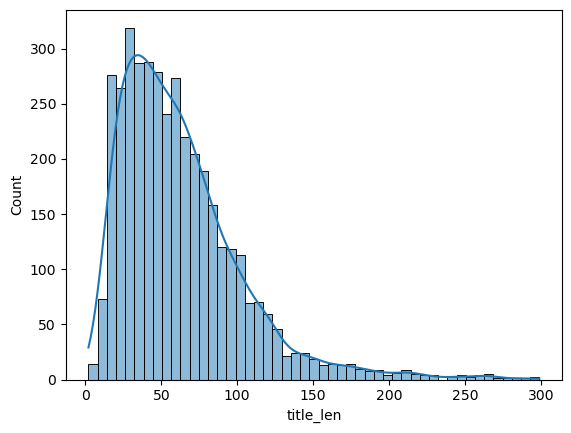

In [29]:
sns.histplot(data=df, x="title_len", kde=True);

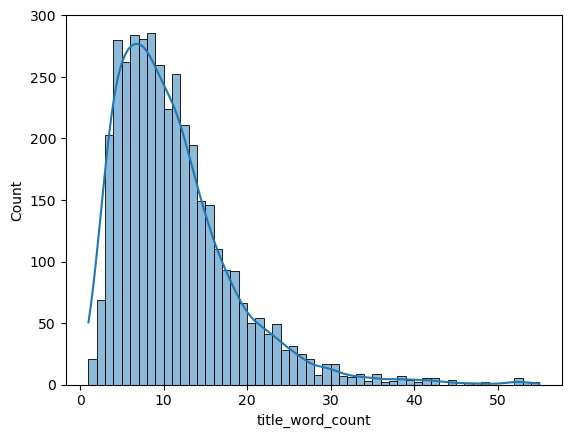

In [30]:
sns.histplot(data=df, x="title_word_count", kde=True);

In [31]:
df.describe(exclude=[object])  

,label,title_word_count,title_len,post_word_count,post_len,emoji_num,emoji_post
count,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000
mean,0.490779,11.070697,62.437244,44.424949,254.692111,0.022029,0.019467
std,0.499979,7.165345,40.521917,127.124875,755.843437,0.166427,0.138178
min,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.000000,33.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,10.000000,54.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,14.000000,81.000000,37.000000,191.000000,0.000000,0.000000
max,1.000000,55.000000,299.000000,2400.000000,14044.000000,3.000000,1.000000


In [32]:
df['title_len'].skew()

1.6930677133748218

In [33]:
df['title_word_count'].skew()

1.7314477227455667

The skew of `title_len` and `title_word_count` is very similar.  
This is to be expected as they are describing the different aspects of the same feature.

In [34]:
user_list = list(df['user'].unique())
len(df['user'].unique())

2750

In [35]:
# This is not being used anywhere.
# This is just to gather and store all information 
# into a dictionary, with user as the key.
# information includes number of post for
# ns, ps and total
user_behave_dict = {}
label_list = ['ns', 'ps']
for user in user_list:
    user_post_list = []
    counter = 0
    for idx, label in enumerate(label_list):
        df_temp = df.loc[(df['user']==user) & (df['label'] == idx)]
        post_num = len(df_temp)
        counter = counter+post_num
        user_post_list.append({label+'_post_num':post_num})
    user_post_list.append({'total_post_num':counter})
    user_behave_dict[user] = user_post_list

In [36]:
# this is a slightly better way of building what I want
ns_post_list = []    
for user in user_list:
    df_temp = df.loc[(df['user']==user) & (df['label'] == 1)]
    post_num = df_temp.shape[0]
    ns_post_list.append(post_num)

In [37]:
ps_post_list = []    
for user in user_list:
    df_temp = df.loc[(df['user']==user) & (df['label'] == 0)]
    post_num = df_temp.shape[0]
    ps_post_list.append(post_num)

In [38]:
user_dict = {'user_name':user_list,
             'ns_posts':ns_post_list,
             'ps_posts':ps_post_list}
user_posts_df = pd.DataFrame(user_dict)
user_posts_df['total_posts'] = user_posts_df['ns_posts']+user_posts_df['ps_posts']

In [39]:
user_posts_df.head()

,user_name,ns_posts,ps_posts,total_posts
0,1338h4x,17,0,17
1,tale-wind,24,0,24
2,Focusboy50,1,0,1
3,Nas160,3,0,3
4,blubberpuppers,13,0,13


In [40]:
# Make everything into a function
def make_user_posts_df(df, lablel_list, search='user', on='label'):
    '''This function makes a dataframe counting appearence of search item based on label
    args:
        df: the dataframe to search through
        label_list: name of the labels in a list
        search: colmun of unique entires for the original dataframe to search on
        on: colmun of original data frame which labels the entires as 0, 1, 2...
    out:
        final_df: dataframe that contains the occurance of each unique entry based on label
    '''
    # make unique list of search object
    unique_list = list(df[search].unique())
    unique_dict = {search:unique_list}
    # run through each label
    for i, label in enumerate(label_list):
        temp_list = []
        # run through unique list of search object
        for unique_val in unique_list:
            df_temp = df.loc[(df[search]==unique_val) & (df[on] == i)]
            post_num = df_temp.shape[0]
            temp_list.append(post_num)
        # store the unique list to the dictionary
        unique_dict[label] = temp_list
    # convert the dictionary to dataframe
    final_df = pd.DataFrame(unique_dict)
    # sum it all up
    final_df['sum'] = final_df[label_list[0]]
    for label in label_list[1:]:
        final_df['sum'] = final_df['sum'] + final_df[label]
    return final_df

In [41]:
make_user_posts_df(df, ['ns, ps'])

,user,ns,ps,sum
0,1338h4x,0,17,17
1,tale-wind,0,24,24
2,Focusboy50,0,1,1
3,Nas160,0,3,3
4,blubberpuppers,0,13,13
...,...,...,...,...
2745,b151,1,0,1
2746,ipoopup,1,0,1
2747,gracekk24PL,1,0,1
2748,MrRoboto12345,1,0,1


In [42]:
user_posts_df.loc[(user_posts_df['ps_posts'] != 0) & (user_posts_df['ns_posts'] != 0)]

,user_name,ns_posts,ps_posts,total_posts
120,MoonieSarito,2,1,3
284,Tail_sb,1,1,2
453,aperson7780,1,1,2
507,Frocharocha,42,1,43
561,ddudegames,1,1,2
593,MarineKingPrime_,1,1,2
596,Ragnara92,1,1,2
795,schuey_08,2,1,3
835,Filmfan345,1,1,2


Out of the 3904 posts collected, only 2750 users are unique.  
This means that there are many users who posted more than 1 post.  
They are probably the very active users.  
To my surprise, the number of users who posts on both `r/nintendo` and `r/playstation` is very few...  
There are only 9 users out of 2750 unique users in total...  
Does this mean that the users who use `r/nintendo` usually will not use `r/playstation`?  
Anyways, this should be a good news for me, as this means that the wordings should be rather far apart in the vector space.  

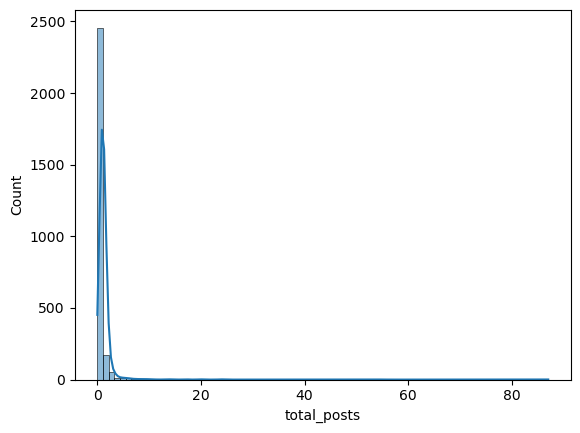

In [43]:
sns.histplot(data=user_posts_df, x="total_posts", kde=True, bins=80);

Majority of the users only post 1 single post in the data collected.

In [44]:
user_posts_df.sort_values(by='total_posts', ascending=False).head(10)

,user_name,ns_posts,ps_posts,total_posts
31,Riomegon,87,0,87
9,RoboticOperatingBudd,82,0,82
46,razorbeamz,55,0,55
507,Frocharocha,42,1,43
131,Amiibofan101,35,0,35
1,tale-wind,24,0,24
18,Asad_Farooqui,24,0,24
58,LinkWink,20,0,20
537,harushiga,20,0,20
0,1338h4x,17,0,17


Seems that `r/nintendo` users topped the chart for posting the most posts?  
Maybe the playstation users are restricted in the number of posts they can make, or simply because playstation have no activity, since Nintendo have the largest number of exclusive games.

## Prelim model

This section, a very basic model will be built to facilitate further EDA.  
Model will not use stemming and lemmatization.  
It will first filter the stop words.  
Word cloud is generated for asthetic purpose.  
Then data is fitted into the model pipeline, with minimum document frequency set at 5.  
TF-IDF is used for the basic model.  
Model also uses Multinominal Naive Bayes.  

In [45]:
nltk_stop_words = set(stopwords.words('english'))

In [46]:
my_stop_words = set(text.ENGLISH_STOP_WORDS.union(nltk_stop_words))

In [47]:
list_of_stop_words = [my_stop_words, STOPWORDS, {'let'}] # {'let'} is included as stop_words inconsistent warning is showing up'

In [48]:
my_stop_words = set().union(*list_of_stop_words)

In [49]:
cvec = CountVectorizer(stop_words=my_stop_words, min_df=5)

In [50]:
cvec.fit(df['title'])

CountVectorizer(min_df=5,
                stop_words={'a', 'about', 'above', 'across', 'after',
                            'afterwards', 'again', 'against', 'ain', 'all',
                            'almost', 'alone', 'along', 'already', 'also',
                            'although', 'always', 'am', 'among', 'amongst',
                            'amoungst', 'amount', 'an', 'and', 'another', 'any',
                            'anyhow', 'anyone', 'anything', 'anyway', ...})

In [51]:
X_train = cvec.transform(df['title'])

In [52]:
X_train.shape

(3904, 998)

In [53]:
word_vector = X_train.toarray()

In [54]:
feature_name = cvec.get_feature_names_out()

In [55]:
count_vectorised_df = pd.DataFrame(data=word_vector, columns=feature_name)

In [56]:
count_vectorised_df.shape

(3904, 998)

In [57]:
count_list = count_vectorised_df.sum()

In [58]:
count_df = pd.DataFrame(data=count_list, columns=['count'])

In [59]:
count_df.sort_values('count', ascending = True).tail(15)

,count
play,95
history,100
years,103
got,111
ps4,124
day,148
playstation,166
super,196
new,235
games,276


Key give away words present here are as follows:  
nintendo: nintendo, switch, mario, super (commonly associated with mario)  
playstation: ps5, playstation, ps4  

<AxesSubplot: >

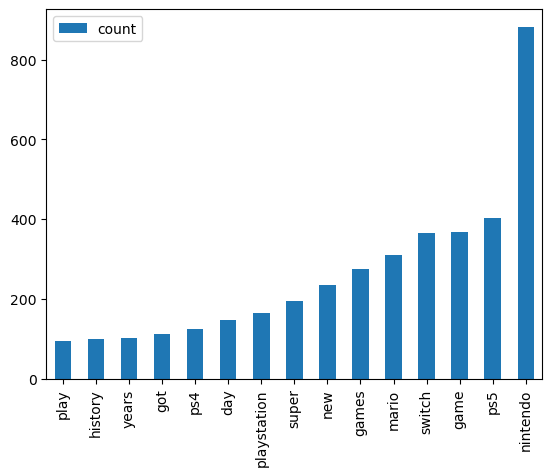

In [60]:
count_df.sort_values('count', ascending = True).tail(15).plot(kind='bar')

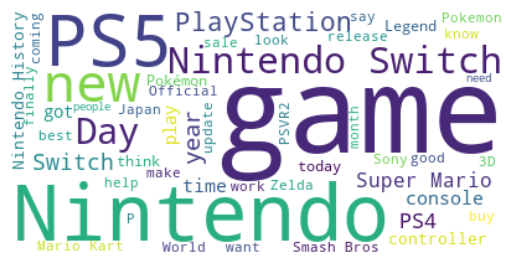

In [61]:
# Start with one review:
text = " ".join(title for title in df['title'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=my_stop_words, background_color="white", max_words=50).generate(text)

# Display the generated image:
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

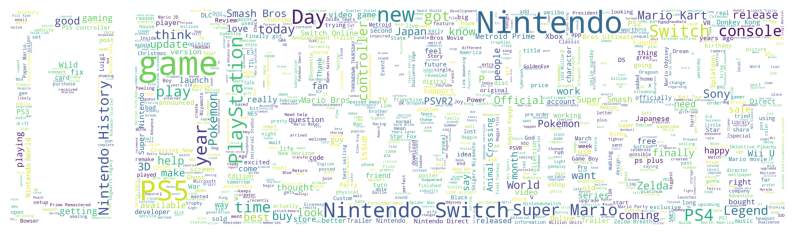

In [73]:
#load mask image from a file
mask = np.array(Image.open('../img/nintendo.png'))

#create a word cloud object with some parameters
wc = WordCloud(stopwords=my_stop_words, background_color='white', max_words=1000, mask=mask)

text = pd.Series(text)

#generate the word cloud from text data
wc.generate(text.str.cat(sep=' '))

#plot the word cloud using matplotlib.pyplot module
plt.figure(figsize=(10,15))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [75]:
# Save the image in the img folder:
wordcloud.to_file("../img/ntd_ps_1st.png");
wc.to_file('../img/ntd.png');

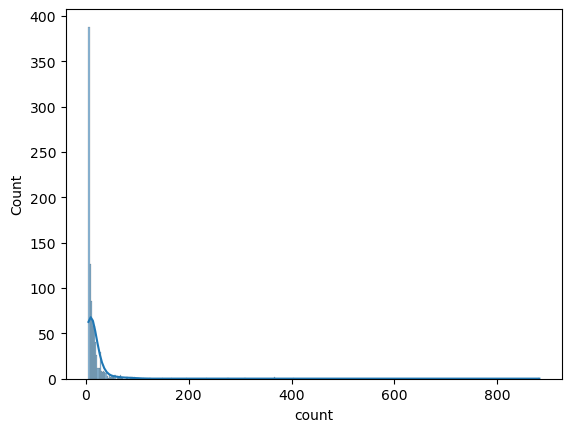

In [63]:
sns.histplot(data=count_df, x='count', kde=True);

The post data is obviously skewed.   
This means that if Navive bayes were to be used, the Guassian Naive Bayes can not be used.  
The correct model to use here should be the `Multinomial Naive Bayes`.  
Also, a check with scikit-learn documentation confirms my theory.  

In [64]:
word_count_sum = X_train.sum(axis=0)
word_counts_array = word_count_sum.ravel()

In [65]:
# test for normality
stat, p = shapiro(word_counts_array)
print('Shapiro-Wilk test statistic:', stat)
print('p-value:', p)

Shapiro-Wilk test statistic: 0.24066483974456787
p-value: 0.0


Previously, the entire `df['title']` is used in count vectoriser.  
It was done for the purpose of analysis.  
Now I will split my data set into train and test, then vectorise them using TFIDF.  
After which, a preliminary model will be developed for the purpose of further analysis.  

In [66]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['label'], test_size=0.2, random_state=42)

In [67]:
vectorizer = TfidfVectorizer(stop_words=my_stop_words)
X_train_tfidf = vectorizer.fit_transform(X_train)

In [68]:
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

MultinomialNB()

In [69]:
X_test_tfidf = vectorizer.transform(X_test)

In [70]:
y_pred = clf.predict(X_test_tfidf)

In [71]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

Accuracy: 0.9154929577464789
Confusion matrix:
 [[343  39]
 [ 27 372]]


In [72]:
y_pred_train = clf.predict(X_train_tfidf)

In [73]:
print('Accuracy:', accuracy_score(y_train, y_pred_train))
print('Confusion matrix:\n', confusion_matrix(y_train, y_pred_train))

Accuracy: 0.9817483189241114
Confusion matrix:
 [[1582   24]
 [  33 1484]]


Make the steps taken above into a pipeline.  
This will be more user friendly!  

In [74]:
# make a pipeline ==> make my own class? 
steps_taken = [
                ('tfid', TfidfVectorizer(stop_words=my_stop_words)),
                ('Multinomial_Naive_Bayes', MultinomialNB())
                ]
tfidf_pipeline = Pipeline(steps_taken)

In [75]:
tfidf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfid',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'across',
                                             'after', 'afterwards', 'again',
                                             'against', 'ain', 'all', 'almost',
                                             'alone', 'along', 'already',
                                             'also', 'although', 'always', 'am',
                                             'among', 'amongst', 'amoungst',
                                             'amount', 'an', 'and', 'another',
                                             'any', 'anyhow', 'anyone',
                                             'anything', 'anyway', ...})),
                ('Multinomial_Naive_Bayes', MultinomialNB())])

In [76]:
y_pred_pipe = tfidf_pipeline.predict(X_test)

In [77]:
print('Accuracy:', accuracy_score(y_test, y_pred_pipe))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_pipe))

Accuracy: 0.9154929577464789
Confusion matrix:
 [[343  39]
 [ 27 372]]


Write a `print_confusion_matrix()` function.  

In [78]:
def print_confusion_matrix(y_actual, y_pred):
    cf_matrix = confusion_matrix(y_actual, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

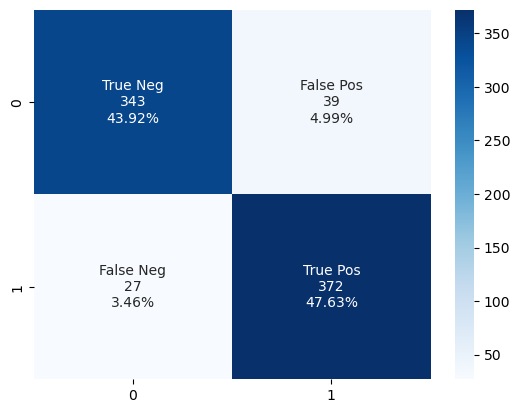

In [79]:
print_confusion_matrix(y_test, y_pred_pipe)

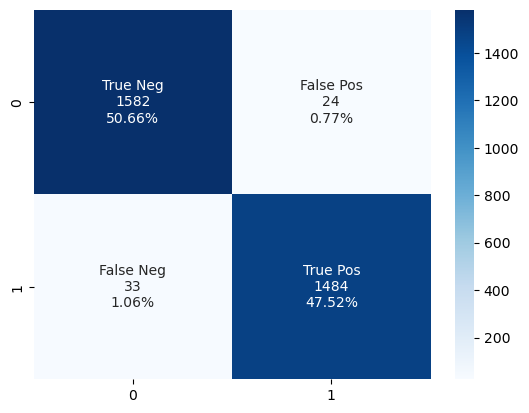

In [80]:
print_confusion_matrix(y_actual=y_train, y_pred=y_pred_train) # showing the training set results for comparison

Looking at the percentages, the traning of the model is slightly over fitted.  
It have a slightly higher True Negative and True Positive rate, which was not achieved when making classifications using the test set.  
This is still acceptable, given this is a investigative preliminary model.  
It should be generalised however.  
So I will employ methods like having a minimum document frequency, removing some words etc.  

In [81]:
def metrics_for_model(y_true, y_pred):
    '''find the relavent metrics from confusion metrics
    arg:
        y_true: true value for y
        y_pred: predicted value for y
    out:
        pre: precison score
        rec: recall score
        f1: f1 socre
    '''
    tn, fp, fn, tp =confusion_matrix(y_true, y_pred).ravel()
    pre = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1 = 2*(pre*rec)/(pre+rec)
    print(f"The recall of this inference is: {rec}")
    print(f"The precision of this inference is: {pre}")
    print(f"The f1 score for this inference is: {f1}")
    return pre, rec, f1

In [82]:
metrics_for_model(y_test, y_pred);

The recall of this inference is: 0.9323308270676691
The precision of this inference is: 0.9051094890510949
The f1 score for this inference is: 0.9185185185185184


The four common metrics for classifiers are:

1. Accuracy: This is the proportion of correct predictions made by the model, i.e., the number of true positives and true negatives divided by the total number of samples. However, accuracy may not be the best metric to use when the classes are imbalanced.

2. Precision: This is the proportion of true positives among the predicted positives, i.e., the number of true positives divided by the sum of true positives and false positives. Precision is a good metric to use when the cost of false positives is high.

3. Recall: This is the proportion of true positives among the actual positives, i.e., the number of true positives divided by the sum of true positives and false negatives. Recall is a good metric to use when the cost of false negatives is high.

4. F1 score: This is the harmonic mean of precision and recall, i.e., 2 * precision * recall / (precision + recall). The F1 score is a good metric to use when both precision and recall are important.

---
With all the components ready, I can make this into a class object with various mathods to simple uses!

In [83]:
class NBModel(object):
    '''A class to create a quick and dirty preliminary Multinomial NB Model
    '''
    def __init__(self, df, stop_words):
        self.df = df
        self.stop_words = stop_words
    
    def split_data(self, test_size=0.2, random_state=42):
        '''splits the data in df
        args:
            test_size: percentage of data used for testing. They are not fed into training. default=0.2
            random_state: random_state to ensure same anser. default = 42, cus 42 is the answer to everything. I just dunno the question Xp
        '''
        X_train, X_test, y_train, y_test = train_test_split(self.df['title'], self.df['label'], test_size=test_size, random_state=random_state)
        self.X_train = X_train
        self.X_test = X_test
        self.y_test = y_test
        self.y_train = y_train
    
    def training(self, vectorizer='tfidf', n_gram_range = (1,1), min_doc_f = 5 ):
        '''train model with portion of data used for training
        args:
            vectorizer: what method to use to vectorise the words. 
                        availabe methods {'tfidf','cvec'}
                        default = 'tfidf'
        '''
        if vectorizer == 'tfidf':
            steps_taken = [
                    ('tfid', TfidfVectorizer(stop_words=self.stop_words, 
                                             ngram_range = n_gram_range,
                                             min_df=min_doc_f,)),
                    ('Multinomial_Naive_Bayes', MultinomialNB())
                    ]
        elif vectorizer == 'cvec':
            steps_taken = [
                    ('tfid', CountVectorizer(stop_words=self.stop_words,
                                             ngram_range = n_gram_range, 
                                             min_df=min_doc_f,)),
                    ('Multinomial_Naive_Bayes', MultinomialNB())
                    ]
        else:
            print('No such vectoriser included! Defaulting to TFIDF.')
            steps_taken = [
                    ('tfid', TfidfVectorizer(stop_words=self.stop_words, 
                                             ngram_range=n_gram_range, 
                                             min_df = min_doc_f,)),
                    ('Multinomial_Naive_Bayes', MultinomialNB())
                    ]            
        self.nb_pipeline = Pipeline(steps_taken)
        
    def fitting(self):
        '''Fit the model and create a trained/ fitted model
        '''
        self.fitted_model = self.nb_pipeline.fit(self.X_train, self.y_train)
    
    def make_prediction(self, X=None):
        '''Make prediction using datas
        args:
            X: df colmun of data to be predicted, in same format as df
        '''
        if X == None:
            y_pred = self.fitted_model.predict(self.X_test)
        else:
            y_pred = self.fitted_model.predict(X)
        self.y_pred = y_pred
    
    def confusion_matric(self):
        '''Make a confusion matrics with self.y_test and self.y_pred
        args:
            y_actual: actual label of y
            y_pred: predicted lable of y
        '''
        self.cf_matrix = confusion_matrix(self.y_test, self.y_pred)
        group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = ["{0:0.0f}".format(value) for value in
                        self.cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in
                             self.cf_matrix.flatten()/np.sum(self.cf_matrix)]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
                  zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(self.cf_matrix, annot=labels, fmt='', cmap='Blues')
        
    def other_scores(self):
        '''Find other socres like recall, precision and f1
        '''
        try: 
            tn, fp, fn, tp = self.cf_matrix.ravel()
        except Exception as e:
            print(e)
            print("create cf_matrix now...")
            self.confusion_matric()
            print("done, retry...")
            tn, fp, fn, tp = self.cf_matrix.ravel()
        pre = tp/(tp+fp)
        rec = tp/(tp+fn)
        f1 = 2*(pre*rec)/(pre+rec)
        print(f"The recall of this inference is: {rec}")
        print(f"The precision of this inference is: {pre}")
        print(f"The f1 score for this inference is: {f1}")
        return pre, rec, f1
    
    def save_fitted(self, name):
        '''save fitted model as joblib file
        '''
        joblib.dump(self.fitted_model, '../model/'+name+'.joblib')
        
    def load_fitted(self, path):
        '''load saved joblib model
        '''
        self.fitted_model = joblib.load(path)
        return self.fitted_model
    
    def check_existance(self, word):
        '''Check if a word exists in the corpus
        '''
        if word in self.nb_pipeline[0].vocabulary_:
            print(f"{word} exists in the corpus")
        else:
            print(f"{word} does not exist in the corpus")
            
    def i_lazy(self):
        '''1 command to run it all for a lazy person like me =)
        '''
        self.split_data()
        self.training()
        self.fitting()
        self.make_prediction()
        self.confusion_matric()
        self.other_scores();

'NBModel' object has no attribute 'cf_matrix'
create cf_matrix now...
done, retry...
The recall of this inference is: 0.9122807017543859
The precision of this inference is: 0.914572864321608
The f1 score for this inference is: 0.9134253450439146


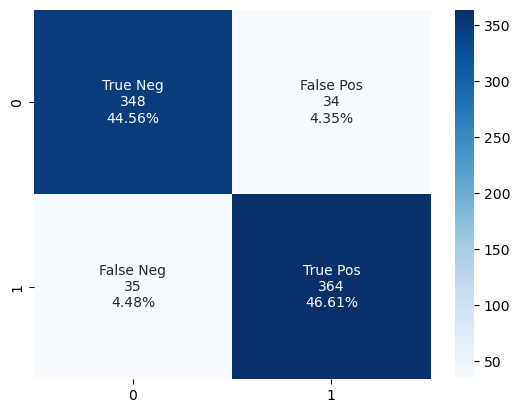

In [84]:
nb_model = NBModel(df, my_stop_words)
nb_model.split_data()
nb_model.training()
nb_model.fitting()
nb_model.make_prediction()
nb_model.other_scores();

In [85]:
nb_model.check_existance('asdsfhsnjkfdvb')

asdsfhsnjkfdvb does not exist in the corpus


From above, I see that the model is slightly overfitted with the training data.  
The percentage of false nagtive and flase postives are higher in the test set compared to the training set.  
However, simply by looking at the small test sample, the difference doesn't seem to be much.

---
In this very basic model, the model performance of the model is rather good.  
This is because the gave away words are not being removed.  
In this case, 0 represents `PlayStation` and 1 represents `Nintendo`.  
There are 38 posts that are actually from `Nintendo` being classified as from `PlayStstion`.  
There are 29 posts from `PlayStation` that are being classified as from `Nintendo`.  
The recall, precision and f1 scores are all listed above, and they show pretty good results.  

In [86]:
nb_model.save_fitted('prelim_model')

In [87]:
loaded_model = nb_model.load_fitted('../model/prelim_model.joblib')

From this model, there are a few problems that can be seen.  
1st is that weblinks will be considered as a single word.  
This will make me unable to extract out the useful information that may appear in the link.  
Also, only a single word is tokenised.  
Stemming and Lematiziation was not used.  
I can also include n-grams as feature engineering.    

## Further EDA

Now, let us test the model by throwing in some random words.

In [88]:
whatever = pd.DataFrame({'title': ['game', 'nintendo', 'playstaion', 'haha', 'fun', 'graphics', 'mario', 'spiderman', 
                                   'meh', 'what', 'new', 'a', 'horizons', 'try', 'ajdisajsbjacvbsjdf', '🧑‍🎤👩‍🎤👨‍🎤', 'got', 'day']})

In [89]:
whatever.T # Transposed for easier viewing

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
title,game,nintendo,playstaion,haha,fun,graphics,mario,spiderman,meh,what,new,a,horizons,try,ajdisajsbjacvbsjdf,🧑‍🎤👩‍🎤👨‍🎤,got,day


In [90]:
y_eda_pred = loaded_model.predict(whatever['title'])

In [91]:
whatever['pred'] = y_eda_pred
whatever.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
title,game,nintendo,playstaion,haha,fun,graphics,mario,spiderman,meh,what,new,a,horizons,try,ajdisajsbjacvbsjdf,🧑‍🎤👩‍🎤👨‍🎤,got,day
pred,1,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1


both `game` and `fun` are from nintendo.   
but nintendo lacks `graphics` =(  
`mario` is correctly identified from nintendo as well.  
`spiderman` is correctly identified to be from playstation.  
for some reason `new` is from nintendo.  
I hypothesised that it is because of animal crossing new horizons, and upon checking, this seems to be the case.   
However, this model have a major flaw.  
As long as the model doesn't recognise the word, it will decide that it is from playstation.  
Or rather, this the Out-Of-Vocabulary problem.  
When a classifier encounters a new or unseen word that is not present in the training data, it may not know how to classify it and may assign it to the negative group by default.   
What I can do, is to scrape for more data.   
If not add the new data into training, if it is above the set treshold for count appearance.  
One example is the emojicons that showed up in a nintendo post.  
It is not being entered into the TFIDF matrix since it is only 1 ocurrance.  
Because it is not seen by the model before, the simple model predicts that it comes from playstation.  
This can lead to errors in the classification results.
To solve this problem, or at least give a warning, I added method `.check_existance()` to my `NBModel` class.  
A function is also implemented below for this check.

In [92]:
def check_corpus(model, word):
    if word in model[0].vocabulary_:
        print(f"{word} in corpus")
    else:
        print(f"{word} not in corpus")

In [93]:
check_corpus(loaded_model, 'asdsfhsnjkfdvb')

asdsfhsnjkfdvb not in corpus


In [94]:
check_corpus(loaded_model, '🧑‍🎤👩‍🎤👨‍🎤')

🧑‍🎤👩‍🎤👨‍🎤 not in corpus


These emojis are not in corpus because they are being filtred out.  

In [95]:
check_corpus(loaded_model, 'nintendo')

nintendo in corpus


Also, the model included some common words, such as `got` and `day`, probably doesn't hurt to have them removed?  
At least for the single word cases like this... 
Just give it a try.

In [96]:
list_of_stop_words = [my_stop_words, {'got', 'day'}]
my_stop_words = set().union(*list_of_stop_words)

The recall of this inference is: 0.9122807017543859
The precision of this inference is: 0.9168765743073047
The f1 score for this inference is: 0.9145728643216079


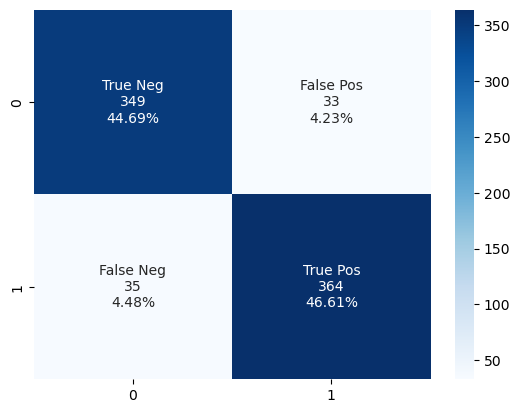

In [97]:
nb_model_2 = NBModel(df, my_stop_words)
nb_model_2.i_lazy()

From the result, it can be seen that both true negative and true positive in the test set have not changed much.  
True negative increased by 1.  
This means, for the test set I am using, removing the words `got` and `day` did not affect it much.  
Either, the words themselves didn't appear in the test set too frequently.  
Or, it really doesn't affect much, becasue the TF-IDF score is low.  

---
now  try the same with `nintendo` and `playstation`.

The recall of this inference is: 0.8646616541353384
The precision of this inference is: 0.9078947368421053
The f1 score for this inference is: 0.8857509627727858


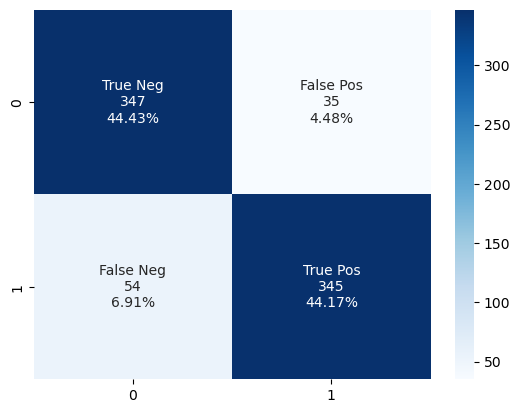

In [98]:
list_of_stop_words = [my_stop_words, {'nintendo', 'playstation'}]
my_stop_words = set().union(*list_of_stop_words)
nb_model_3 = NBModel(df, my_stop_words)
nb_model_3.i_lazy()

In [99]:
nb_model_3.save_fitted('prelim_model')

Removing both `nintendo` and `playstation` actually have a significant impact!  
`nintendo` heavily impacts the ammount of true positive.  
By removing `nintendo`, it is now harder for the algorithm to realise that the post title actually comes from `nintendo`.  
This resulted in an increase in Flase Negatives and decrease in True Positives.   
This means that `nintendo` is a key label for the model.  

All 3 scores, recall, precision and f1 dropped a little.   
It is still not too bad.  
These experiments show that:
1. Frequency of word appearing does not have a direct relationship to performance of model, as can be seen from removing 'got' and 'day'. This maybe thanks to TF-IDF?
2. give away words or maybe 'leakage' words like 'nintendo' and 'playstation' are indeed very important. However, maybe becasue the test size is small, plus the document length is short, it doesn't matter as much?  

---
Additional things I can try are using n-grams on my tfidf.  
Lowering the number of words needed to be included in tfidf.
Stemming, lemmatizing and many more.  
Some og them will be covered in my modelling notebook.  
However, it should be noted that if the treshold for tfid to accept words are lowered, then a problem can be that over fits.  

In [100]:
# Before I move on, I like the current list of stopwords. Save them as a file
with open('../data/stopwords.pkl', 'wb') as f:
    pickle.dump(my_stop_words, f)

## Conclusion

To conclude off, I have examined the data I collected using PRAW.   
Features like user, posting habbits like use of emojis and use of pictures were examined.
The number of occurance of words are counted, length of titles are also examined.
Distribution of number of words used to form title are presented graphically.  
Occurance of each words are for the top words are also examined.  

A word cloud is generated:  
<img src='../img/ntd_ps_1st.png'></img>

Then, a simple basic and most naive model that may not even worth 1 point in GA is built.  
It uses TFIDF and Multinominal Naive Bayes.   
Multinominal Naive Bayes is used becuase the text data is not normally distributed.  
TFIDF is used because the number of occurance of the term is not as important as the term itself.   
Hence I also look at the number of appearance of a term in a single document (1 title).  
The results are good, simply because the give away words are not removed.  

Results for the most basic NB model are:  

- The recall of this inference is: 0.93
- The precision of this inference is: 0.91
- The f1 score for this inference is: 0.92

The condusion matrix is:  
<img src='../img/basic_nb.png'></img>

Removing the key give away words like `nintendo` and `playstation` decreases the model performance slightly, but not too much.  
Removing words like `got` and `day` had no impact on the test set.  
This result is very likely due to the use of TF-IDF in the tokeninsation process.  